# Linear regression example

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import time

In [2]:
#Get data from csv file
data = pd.read_csv("LinearExample/insurance.csv") 
# Preview the first 5 lines of the loaded data 
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Check bmi distribution

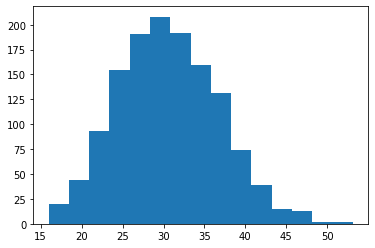

In [3]:
dataNp = data.to_numpy()
bmi = dataNp[:,2]
bmi = bmi.astype('float64')

plt.hist(bmi, bins=15)
plt.show()

### Check charges distribution

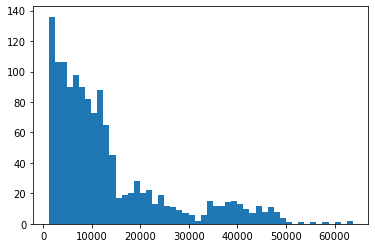

In [4]:
dataNp = data.to_numpy()

age = dataNp[:, 0]
age = age.astype('float64')
sex = dataNp[:, 1]
children = dataNp[:, 3]
charges = dataNp[:, 6]
charges = charges.astype('float64')


plt.hist(charges, bins=50)
plt.show()

Charges distribution has 3 clusters, most of the cases fall in the range 0 - 10000 aprox

### Checking relationship between age and charges

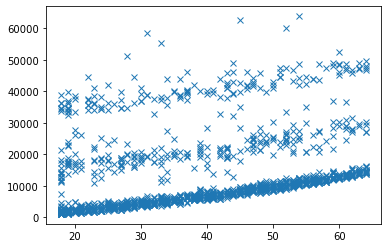

In [5]:
plt.plot(age, charges, 'x');

Checking plot, seems that there is a linear relation between these variables. It's very spreaded though.

Let's try to find a linear equation that fits this data just for fun.

With this visualization, 3 clusters are visible.
How do they relate with other variables?
How can I find the relation between a cluster and another variable(s)?

### Training the model to predict charges uisng age

In [6]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Normalize data

In [7]:
#Get normalize values before spliting sets
ageNorm = np.linalg.norm(age)
chargesNorm = np.linalg.norm(charges)

#divide train and test dataset
X_train, X_test, y_train, y_test = train_test_split(age, charges, train_size=0.65,test_size=0.35)

#Get data sample sizes
trainDataSize = X_train.size
testDataSize = y_test.size

#normalize data
X_train =  X_train / ageNorm
X_test =  X_test / ageNorm
y_train = y_train / chargesNorm
y_test = y_test / chargesNorm

### Plot after normalization

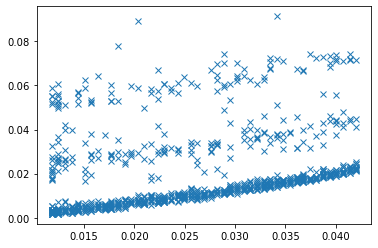

In [8]:
plt.plot(X_train, y_train, 'x');

### Use sklearn to train model and then plot calculated function and train data together

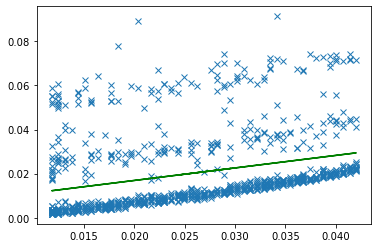

B0: [0.00553524], B1: [0.5682154]


In [9]:
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

slbeta0 = linr.intercept_
slbeta1 = linr.coef_[0]

yplot = X_train * slbeta1 + slbeta0

plt.plot(X_train, y_train, 'x');
plt.plot(X_train, yplot, 'g')
plt.show()

print(f'B0: {slbeta0}, B1: {slbeta1}')

### Evaluate model with coeficients provided by sklearn, Plot error distribution

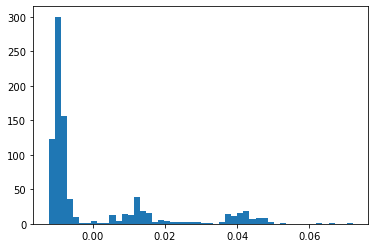

In [10]:
slyhat = X_train * slbeta1 + slbeta0
error = y_train - slyhat

plt.hist(error, bins=50)
plt.show()

Error distribution shows 3 kernels, leftmost (negative) shows where most of the data is present.

### Use pytorch to train model

In [11]:
n_epochs = 400
#batch_size_train = round(trainDataSize / 2)
batch_size_train = trainDataSize
batch_size_test = testDataSize
learning_rate = 0.01
momentum = 0.9
log_interval = 10

# transform to torch tensor
tensor_train_x = torch.Tensor(X_train.reshape(-1, 1))
tensor_train_y = torch.Tensor(y_train.reshape(-1, 1))

# create your datset
train_data = TensorDataset(tensor_train_x, tensor_train_y)

#Create loader using data
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size_train,
    shuffle=True)

# transform to torch tensor
tensor_test_x = torch.Tensor(X_test.reshape(-1, 1))
tensor_test_y = torch.Tensor(y_test.reshape(-1, 1))

# create your datset
test_data = TensorDataset(tensor_test_x, tensor_test_y)

#Create loader using data
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size_test,
    shuffle=True)

In [12]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)
    
#Network model
network = LayerLinearRegression()

#Configure loss function
LossFunction = nn.MSELoss(reduction='mean')

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.SGD(network.parameters(), lr=learning_rate)

In [13]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [14]:
def train(epoch):
  #Configure network for training
  network.train()

  for batch_idx, (data, target) in enumerate(train_loader):
    
    #set parameters gradients to 0
    optimizer.zero_grad()
    
    #runs model with data and returns result in output
    output = network(data)
    
    #Calculate loss.
    loss = LossFunction(output, target)
    
    #Gradients are calculated
    loss.backward()
    
    #update gradients
    optimizer.step()
    
    #Display iteration statistics
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [15]:
def test():
  #Sets the module in evaluation mode
  network.eval()
  test_loss = 0
  correct = 0
    
  #dont update dynamic computation graph
  with torch.no_grad():
    #for every example in test
    for data, target in test_loader:
      #evaluate the model
      output = network(data)
        
      #acumulate the loss
      test_loss += LossFunction(output, target).item()
      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)
      #print('\nTest set: Avg. loss: {:.6f}\n'.format(test_loss))

In [16]:
#Check accuaracy before training
test()
tic = time.perf_counter()

for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
    
toc = time.perf_counter()

print(f"Time elapsed: {toc - tic:0.4f} seconds")

Train Epoch: 1 	Loss: 0.169710
Train Epoch: 2 	Loss: 0.162998
Train Epoch: 3 	Loss: 0.150746
Train Epoch: 4 	Loss: 0.134385
Train Epoch: 5 	Loss: 0.115438
Train Epoch: 6 	Loss: 0.095386
Train Epoch: 7 	Loss: 0.075555
Train Epoch: 8 	Loss: 0.057043
Train Epoch: 9 	Loss: 0.040676
Train Epoch: 10 	Loss: 0.026992
Train Epoch: 11 	Loss: 0.016254
Train Epoch: 12 	Loss: 0.008478
Train Epoch: 13 	Loss: 0.003477
Train Epoch: 14 	Loss: 0.000911
Train Epoch: 15 	Loss: 0.000338
Train Epoch: 16 	Loss: 0.001269
Train Epoch: 17 	Loss: 0.003207
Train Epoch: 18 	Loss: 0.005688
Train Epoch: 19 	Loss: 0.008310
Train Epoch: 20 	Loss: 0.010745
Train Epoch: 21 	Loss: 0.012752
Train Epoch: 22 	Loss: 0.014179
Train Epoch: 23 	Loss: 0.014954
Train Epoch: 24 	Loss: 0.015075
Train Epoch: 25 	Loss: 0.014598
Train Epoch: 26 	Loss: 0.013617
Train Epoch: 27 	Loss: 0.012255
Train Epoch: 28 	Loss: 0.010642
Train Epoch: 29 	Loss: 0.008910
Train Epoch: 30 	Loss: 0.007176
Train Epoch: 31 	Loss: 0.005540
Train Epoch: 32 	

Train Epoch: 260 	Loss: 0.000316
Train Epoch: 261 	Loss: 0.000316
Train Epoch: 262 	Loss: 0.000316
Train Epoch: 263 	Loss: 0.000316
Train Epoch: 264 	Loss: 0.000316
Train Epoch: 265 	Loss: 0.000316
Train Epoch: 266 	Loss: 0.000316
Train Epoch: 267 	Loss: 0.000316
Train Epoch: 268 	Loss: 0.000316
Train Epoch: 269 	Loss: 0.000316
Train Epoch: 270 	Loss: 0.000316
Train Epoch: 271 	Loss: 0.000316
Train Epoch: 272 	Loss: 0.000316
Train Epoch: 273 	Loss: 0.000316
Train Epoch: 274 	Loss: 0.000316
Train Epoch: 275 	Loss: 0.000316
Train Epoch: 276 	Loss: 0.000316
Train Epoch: 277 	Loss: 0.000316
Train Epoch: 278 	Loss: 0.000316
Train Epoch: 279 	Loss: 0.000316
Train Epoch: 280 	Loss: 0.000316
Train Epoch: 281 	Loss: 0.000316
Train Epoch: 282 	Loss: 0.000316
Train Epoch: 283 	Loss: 0.000316
Train Epoch: 284 	Loss: 0.000316
Train Epoch: 285 	Loss: 0.000316
Train Epoch: 286 	Loss: 0.000316
Train Epoch: 287 	Loss: 0.000316
Train Epoch: 288 	Loss: 0.000316
Train Epoch: 289 	Loss: 0.000316
Train Epoc

### Plot training result with pytorch

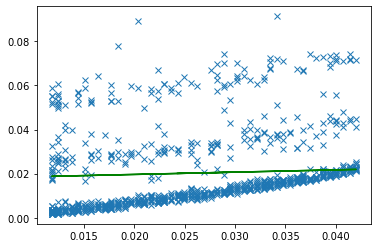

B0: [0.01755333], B1: [[0.10371107]]


In [18]:
beta1, beta0 = network.parameters()

beta0 = beta0.data.numpy()
beta1 = beta1.data.numpy()

yplot = X_train * beta1 + beta0
plt.plot(X_train, y_train, 'x');
plt.plot(X_train, yplot.reshape(-1, 1), 'g')
plt.show()

print(f'B0: {beta0}, B1: {beta1}')

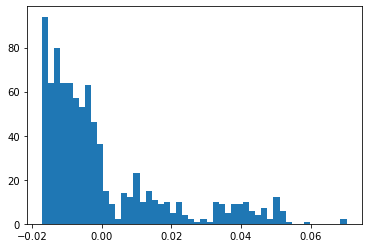

In [19]:
with torch.no_grad():
    yhat = X_train * beta1 + beta0
    error = y_train - yhat

    plt.hist(error.reshape(-1, 1), bins=50)
    plt.show()

### Plot test loss curve

In [31]:
test_counter

[0,
 869,
 1738,
 2607,
 3476,
 4345,
 5214,
 6083,
 6952,
 7821,
 8690,
 9559,
 10428,
 11297,
 12166,
 13035,
 13904,
 14773,
 15642,
 16511,
 17380,
 18249,
 19118,
 19987,
 20856,
 21725,
 22594,
 23463,
 24332,
 25201,
 26070,
 26939,
 27808,
 28677,
 29546,
 30415,
 31284,
 32153,
 33022,
 33891,
 34760,
 35629,
 36498,
 37367,
 38236,
 39105,
 39974,
 40843,
 41712,
 42581,
 43450,
 44319,
 45188,
 46057,
 46926,
 47795,
 48664,
 49533,
 50402,
 51271,
 52140,
 53009,
 53878,
 54747,
 55616,
 56485,
 57354,
 58223,
 59092,
 59961,
 60830,
 61699,
 62568,
 63437,
 64306,
 65175,
 66044,
 66913,
 67782,
 68651,
 69520,
 70389,
 71258,
 72127,
 72996,
 73865,
 74734,
 75603,
 76472,
 77341,
 78210,
 79079,
 79948,
 80817,
 81686,
 82555,
 83424,
 84293,
 85162,
 86031,
 86900,
 87769,
 88638,
 89507,
 90376,
 91245,
 92114,
 92983,
 93852,
 94721,
 95590,
 96459,
 97328,
 98197,
 99066,
 99935,
 100804,
 101673,
 102542,
 103411,
 104280,
 105149,
 106018,
 106887,
 107756,
 108625

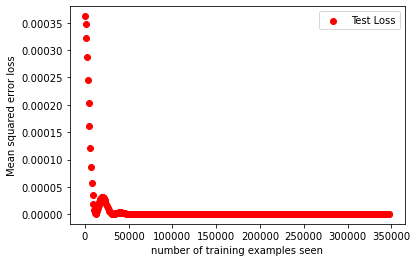

In [30]:
#fig = plt.figure()
#plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Mean squared error loss')
plt.show()

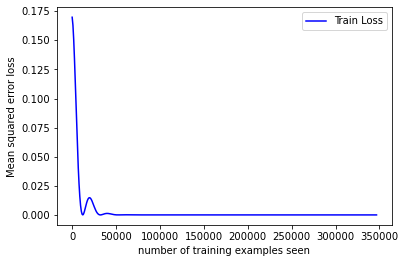

In [29]:
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Mean squared error loss')
plt.show()

### Result analysis

As shown below, model gets stuck with a local minimum resulting in a predicted line which doesn't fit very well the data. Why sklearn always gets a good result?
This are te configuration used epochs = 400
batch size = sample / 4
learning_rate = 0.01
momentum = 0.9

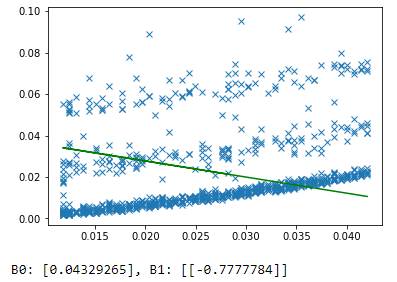

n_epochs = 400
batch_size_train = round(trainDataSize / 2)
batch_size_test = testDataSize
learning_rate = 0.01
momentum = 0.9
log_interval = 10

Error plot from example below, result in a distribution very different from the optimum result

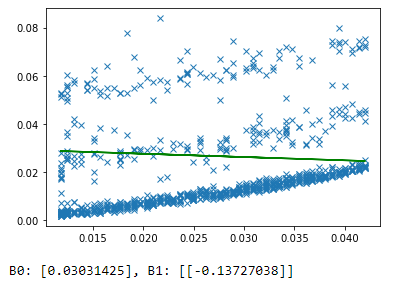

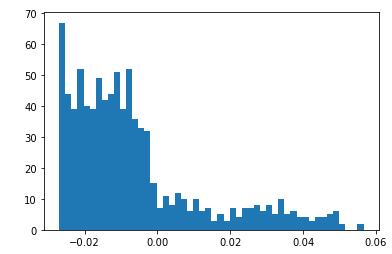

As shown below. data has a cluster with a large number of data, very close eachother with a linear shape, and two less dense more disperse clusters. In the error distribution we can see first a thin but high distribution corresponding to the first cluster, and two more disperse after.

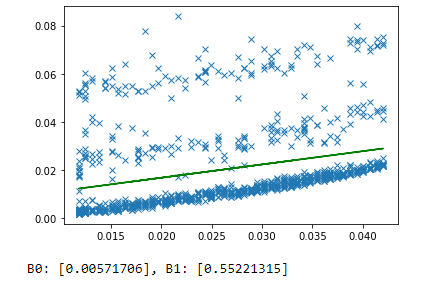

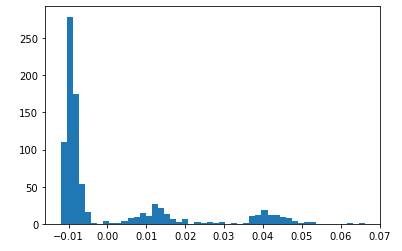

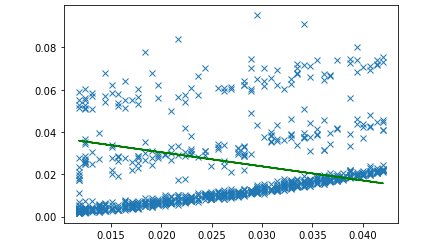

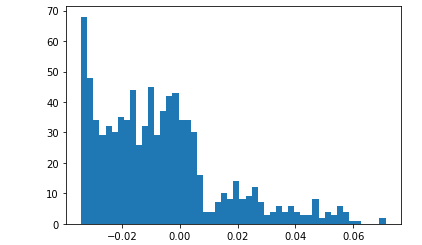

# References

- https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
- https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
- Data was taken from: https://www.kaggle.com/mirichoi0218/insurance

# ToDo

- Sometimes model is not converging, how can I fix this?
- Check other parameters to tune in the model to improve model converging.
- When data is very spread, what is the best approach to get a better result?
- Analize other characteristic from data to check how to better predict charges

# Notes

- Since data is very spread, using an small batch size the model doesn't seems to converge, if I use a bigger batch size, it does better.
- What is the difference between a model and nn.Linear? nn.Module is a neural network containers. Linear is a type of layer